In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, LabelBinarizer
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn import feature_extraction, preprocessing
from torch.cuda import is_available, empty_cache
from torch.nn import Module, Linear, ReLU, Softmax, Dropout, CrossEntropyLoss, BCELoss
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from tqdm.notebook import tqdm
from torch import no_grad, FloatTensor, LongTensor, save
from matplotlib.pyplot import subplots, close
from IPython.display import display, update_display

from pathlib import Path
from urllib.request import urlopen
from random import seed, shuffle


# TODO: remove for real randomness?
SEED = 1234
seed(SEED)
np.random.seed(SEED)

COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
ADDRESS = f"https://raw.githubusercontent.com/propublica/compas-analysis/master/{COMPAS_INPUT_FILE}"

print(f"Looking for file '{COMPAS_INPUT_FILE}' in the current directory...")
path = Path(f"./{COMPAS_INPUT_FILE}")

if not path.exists():
    print("File not found! Downloading from GitHub...")
    with open(path, "wb") as file:
        file.write(urlopen(ADDRESS).read())
    print(f"File '{COMPAS_INPUT_FILE}' download and saved locally.")
else:
    print("File found in current directory.")


empty_cache()
is_available()

Looking for file 'compas-scores-two-years.csv' in the current directory...
File found in current directory.


False

In [167]:
class ClassificatorModel(Module):
    def __init__(self):
        super(ClassificatorModel, self).__init__()
        self.constructor = Linear(15, 10000)
        self.activator = ReLU()
        self.reconstructor = Linear(10000, 50000)
        self.reactivator = ReLU()
        self.cdeonstructor = Linear(50000, 10000)
        self.deactivator = ReLU()
        self.folder = Linear(100000, 1)
        self.softmax = Softmax(1)

    def forward(self, x):
        x = self.constructor(x)
        x = self.activator(x)
        x = self.reconstructor(x)
        x = self.reactivator(x)
        x = self.deconstructor(x)
        x = self.deactivator(x)
        x = self.folder(x)
        x = self.softmax(x)
        return x

In [168]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [169]:
def redraw_graph(drawable, losses_arr, accuracy_arr):
  title = drawable[1].get_title()
  x_label = drawable[1].get_xlabel()
  y_label = drawable[1].get_ylabel()

  drawable[1].cla()
  drawable[1].plot(losses_arr, color="blue", label="losses")
  drawable[1].scatter(len(losses_arr) - 1, losses_arr[-1], c="blue")
  drawable[1].plot(accuracy_arr, color="red", label="accuracy")
  drawable[1].scatter(len(accuracy_arr) - 1, accuracy_arr[-1], c="red")

  drawable[1].set_ylim(bottom=0)
  drawable[1].set_title(title)
  drawable[1].set_xlabel(x_label)
  drawable[1].set_ylabel(y_label)
  drawable[1].set_yscale('symlog')
  drawable[1].legend()
  drawable[1].grid(visible=True)

  drawable[0].show()
  update_display(drawable[0], display_id=drawable[2])


def train_epoch(model, data_loader, optimizer, criterion, device, losses_arr, accuracy_arr, drawable):
  model = model.to(device).train()
  total_loss = 0
  total_accuracy = 0
  with tqdm(desc="Training", unit="batch", total=len(data_loader)) as prbar:
    for features, labels in data_loader:
      # Move Batch to GPU
      features = features.to(device)
      labels = labels.to(device)
      predicted = model(features)
      loss = criterion(predicted, labels.unsqueeze(1))
      # Update weights
      optimizer.zero_grad()
      loss.backward()
      # update weights
      optimizer.step()
      # Update descirption for tqdm
      accuracy = (predicted.argmax(1) == labels).float().mean()
      prbar.set_description(f"Loss: {round(loss.item(), 3)}; Accuracy: {round(accuracy.item() * 100, 3)}")
      prbar.update(1)
      # Update training graph
      losses_arr.append(loss.item())
      accuracy_arr.append(accuracy.item())
      redraw_graph(drawable, losses_arr, accuracy_arr)
      # Updating totals
      total_loss += loss.item()
      total_accuracy += accuracy.item()
    prbar.set_description(f"Loss: {round(total_loss / len(data_loader), 3)}; Accuracy: {round(total_accuracy / len(data_loader) * 100, 3)}")
  return total_loss / len(data_loader), total_accuracy / len(data_loader)


def validate(model, data_loader, criterion, device, losses_arr, accuracy_arr, drawable):
  model = model.eval()
  total_loss = 0
  total_accuracy = 0
  with tqdm(desc="Testing", unit="batch", total=len(data_loader)) as prbar:
    for features, labels in data_loader:
      # Move Batch to GPU
      features = features.to(device)
      labels = labels.to(device)
      predicted = model(features)
      loss = criterion(predicted, labels.unsqueeze(1))
      # Update descirption for tqdm
      accuracy = (predicted.argmax(1) == labels).float().mean()
      prbar.set_description(f"Loss: {round(loss.item(), 3)}; Accuracy: {round(accuracy.item() * 100, 3)}")
      prbar.update(1)
      # Update training graph
      losses_arr.append(loss.item())
      accuracy_arr.append(accuracy.item())
      redraw_graph(drawable, losses_arr, accuracy_arr)
      # Updating totals
      total_loss += loss.item()
      total_accuracy += accuracy.item()
    prbar.set_description(f"Loss: {round(total_loss / len(data_loader), 3)}; Accuracy: {round(total_accuracy / len(data_loader) * 100, 3)}")
  return total_loss / len(data_loader), total_accuracy / len(data_loader)

def fit(model, epochs, train_data_loader, test_data_loader, optimizer, criterion, stopper, device="cuda:0"):
    batch_train_losses = []
    batch_train_accuracy = []
    batch_test_losses = []
    batch_test_accuracy = []

    batch_figure, (batch_train_graph, batch_test_graph) = subplots(1, 2, figsize=(15, 5))
    batch_figure.suptitle("Accuracy/Loss graph")
    batch_train_graph.set_title("Training")
    batch_test_graph.set_title("Testing")
    for graph in (batch_train_graph, batch_test_graph):
      graph.set_xlabel("Batches")
      graph.set_ylabel("Accuracy/Losses")
      graph.grid(visible=True)
    batch_display_id = "batch_graph"
    display(batch_figure, display_id=batch_display_id)

    epoch_train_losses = []
    epoch_train_accuracy = []
    epoch_test_losses = []
    epoch_test_accuracy = []

    epoch_figure, (epoch_train_graph, epoch_test_graph) = subplots(1, 2, figsize=(15, 5))
    epoch_figure.suptitle("Accuracy/Loss graph")
    epoch_train_graph.set_title("Training")
    epoch_test_graph.set_title("Testing")
    for graph in (epoch_train_graph, epoch_test_graph):
      graph.set_xlabel("Epochs")
      graph.set_ylabel("Accuracy/Losses")
      graph.grid(visible=True)
    epoch_display_id = "epoch_graph"
    display(epoch_figure, display_id=epoch_display_id)

    for epoch in range(epochs):
      # Train step
      print(f"Train Epoch: {epoch}")
      epoch_loss, epoch_accuracy = train_epoch(model, train_data_loader, optimizer, criterion, device, batch_train_losses, batch_train_accuracy, (batch_figure, batch_train_graph, batch_display_id))
      epoch_train_losses.append(epoch_loss)
      epoch_train_accuracy.append(epoch_accuracy)
      redraw_graph((epoch_figure, epoch_train_graph, epoch_display_id), epoch_train_losses, epoch_train_accuracy)
      # Test step
      with no_grad():
        print(f"Testing Epoch: {epoch}")
        test_loss, test_accuracy = validate(model, test_data_loader, criterion, device, batch_test_losses, batch_test_accuracy, (batch_figure, batch_test_graph, batch_display_id))
        epoch_test_losses.append(test_loss)
        epoch_test_accuracy.append(test_accuracy)
        redraw_graph((epoch_figure, epoch_test_graph, epoch_display_id), epoch_test_losses, epoch_test_accuracy)

        if stopper.early_stop(np.mean(epoch_test_accuracy)):             
          break

In [170]:
FEATURE_LIST_CONTINUOUS = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_length_of_stay', 'f_length_of_stay']
FEATURE_LIST_CATEGORICAL = ['sex', 'race', 'c_charge_degree']
binarizers = dict()

df = pd.read_csv('compas-scores-two-years.csv', delimiter = ',')
df = df.dropna(subset=["days_b_screening_arrest"])
df = df[(df.days_b_screening_arrest <= 30) & (df.days_b_screening_arrest >= -30) & (df.is_recid != -1) & (df.c_charge_degree != 'O') & (df.score_text != 'N/A')]
df['c_length_of_stay'] = (pd.to_datetime(df['c_jail_out']) - pd.to_datetime(df['c_jail_in'])).dt.days
df['f_length_of_stay'] = (pd.to_datetime(df['c_arrest_date']) - pd.to_datetime(df['c_offense_date'])).dt.days
df['length_of_custody'] = (pd.to_datetime(df['in_custody']) - pd.to_datetime(df['out_custody'])).dt.days
df[['f_length_of_stay']] = df[['f_length_of_stay']].fillna(0)
df.reset_index(inplace=True, drop=True)

labels_dataset = df['two_year_recid']
features_dataset = np.array([]).reshape(len(labels_dataset), 0)
for _, data in {attr: df[attr] for attr in FEATURE_LIST_CONTINUOUS}.items():
  data = scale([float(v) for v in data])
  data = np.reshape(data, (len(labels_dataset), -1))
  features_dataset = np.hstack((features_dataset, data))
for attribute, data in {attr: df[attr] for attr in FEATURE_LIST_CATEGORICAL}.items():
  enc = LabelBinarizer()
  enc.fit(data)
  binarizers[attribute] = enc
  features_dataset = np.hstack((features_dataset, enc.transform(data)))

features_train, features_test, labels_train, labels_test = train_test_split(features_dataset, labels_dataset, test_size=0.1)

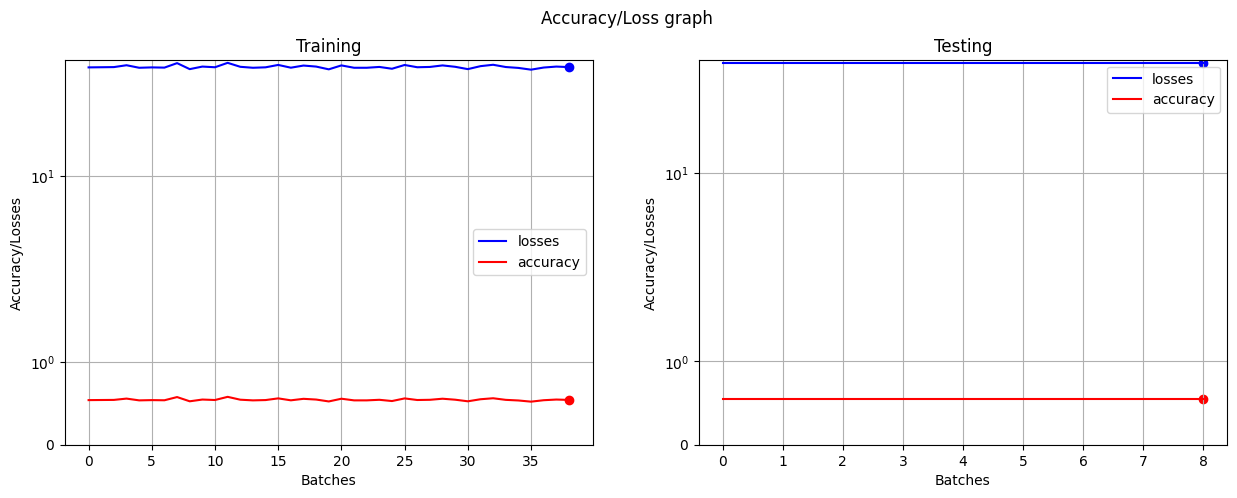

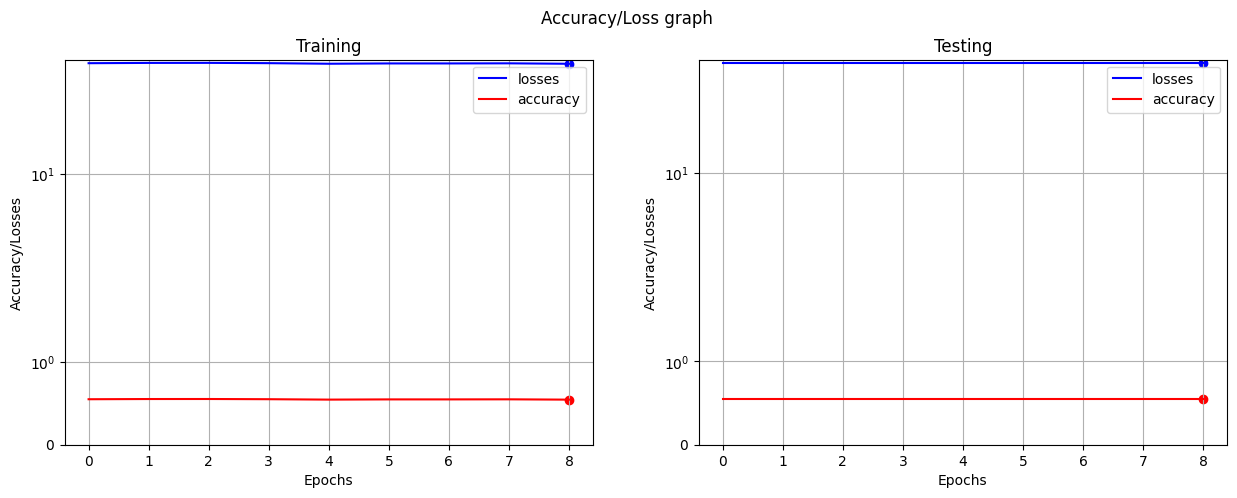

Train Epoch: 0


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

/tmp/ipykernel_2949631/724300008.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  drawable[0].show()


Testing Epoch: 0


Testing:   0%|          | 0/1 [00:00<?, ?batch/s]

Train Epoch: 1


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Testing Epoch: 1


Testing:   0%|          | 0/1 [00:00<?, ?batch/s]

Train Epoch: 2


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Testing Epoch: 2


Testing:   0%|          | 0/1 [00:00<?, ?batch/s]

Train Epoch: 3


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Testing Epoch: 3


Testing:   0%|          | 0/1 [00:00<?, ?batch/s]

Train Epoch: 4


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Testing Epoch: 4


Testing:   0%|          | 0/1 [00:00<?, ?batch/s]

Train Epoch: 5


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Testing Epoch: 5


Testing:   0%|          | 0/1 [00:00<?, ?batch/s]

Train Epoch: 6


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Testing Epoch: 6


Testing:   0%|          | 0/1 [00:00<?, ?batch/s]

Train Epoch: 7


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Testing Epoch: 7


Testing:   0%|          | 0/1 [00:00<?, ?batch/s]

Train Epoch: 8


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Testing Epoch: 8


Testing:   0%|          | 0/1 [00:00<?, ?batch/s]

Train Epoch: 9


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

KeyboardInterrupt: 

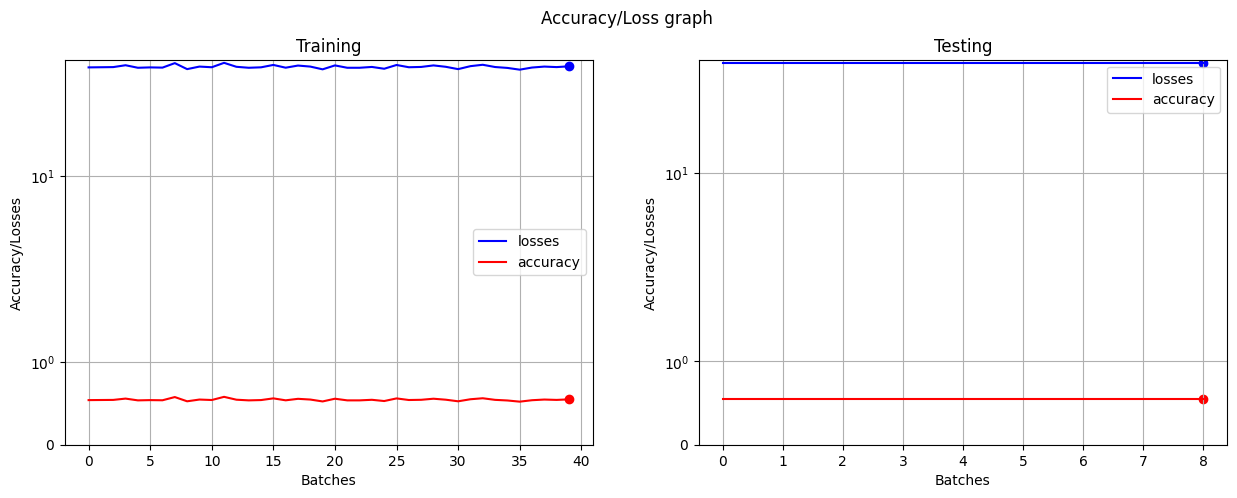

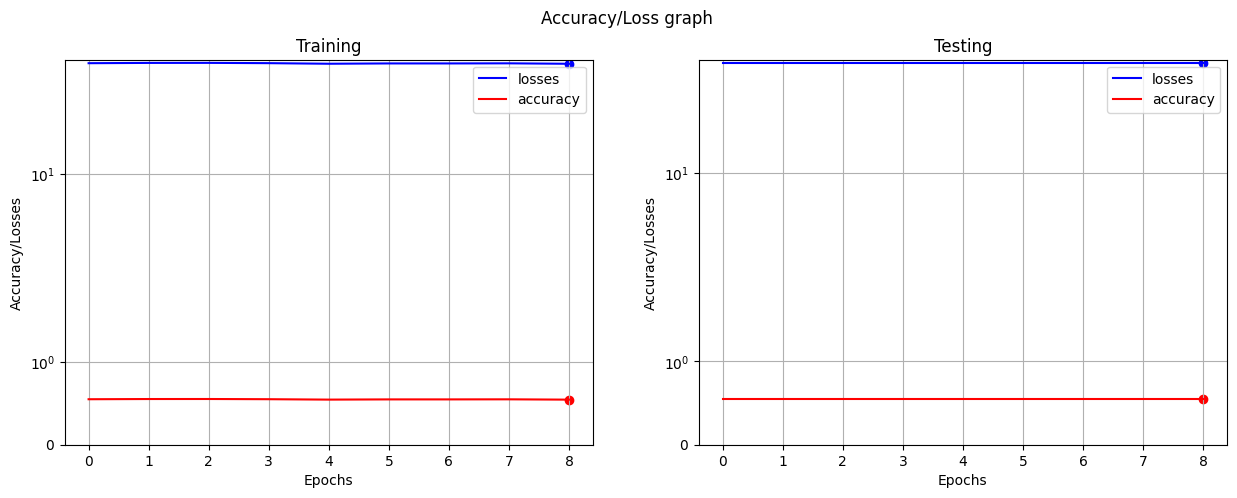

In [171]:
features_train_tensor = FloatTensor(features_train)
labels_train_tensor = FloatTensor(labels_train.to_numpy())
features_test_tensor = FloatTensor(features_test)
labels_test_tensor = FloatTensor(labels_test.to_numpy())

train_dataloader = DataLoader(TensorDataset(features_train_tensor, labels_train_tensor), batch_size=1600, shuffle=True)
test_dataloader = DataLoader(TensorDataset(features_test_tensor, labels_test_tensor), batch_size=1600, shuffle=True)

model = ClassificatorModel()
criterion = BCELoss()
optimizer = Adam(model.parameters(), 1e-4)
early_stopper = EarlyStopper(patience=5, min_delta=0.01)
fit(model, 200, train_dataloader, test_dataloader, optimizer, criterion, early_stopper, "cuda:0" if is_available() else "cpu")

save(model, "./models/classifier.pth")